### This is a simple LGB baseline. You can work for feature engineering.
### The seed is 42, which will bring good luck!


In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

from lightgbm import LGBMRegressor
from multiprocessing import Pool
from sklearn.model_selection import TimeSeriesSplit

import pickle
import gc

import tqdm

n_fold = 10
group_gap = 31
seed = 42

ROOT_PATH = "../../data/"
TRAIN_MARKET_PATH = f'{ROOT_PATH}first_round_train_market_data.csv'
TRAIN_FUNADMENTAL_PATH = f'{ROOT_PATH}first_round_train_fundamental_data.csv'
TRAIN_RETURN_PATH = f'{ROOT_PATH}first_round_train_return_data.csv'

TEST_ROOT_PATH = "../qids_package/"
TEST_MARKET_PATH = f'{TEST_ROOT_PATH}first_round_test_market_data.csv'
TEST_FUNADMENTAL_PATH = f'{TEST_ROOT_PATH}first_round_test_fundamental_data.csv'

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 350)

/Users/lhw/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read data
df_train_market = pd.read_csv(TRAIN_MARKET_PATH)
df_train_return = pd.read_csv(TRAIN_RETURN_PATH)
df_train_fundamental = pd.read_csv(TRAIN_FUNADMENTAL_PATH)

df_test_market = pd.read_csv(TEST_MARKET_PATH)
df_test_fundamental = pd.read_csv(TEST_FUNADMENTAL_PATH)

In [3]:
#merge train dataset and test dataset
def split_time(x):
    df1 = x['date_time'].str.split('d', expand=True)
    df1.columns=['code','s']
    code = df1['code']
    df1 = df1['s'].str.split('p', expand=True)
    df1.columns=['day','time_step']
    df2 = x['date_time'].str.rsplit('p', expand=True)
    df2.columns=['day_s','s']
    df1['day_s'] = df2['day_s']
    df1['code'] = code
    x = pd.concat([x,df1],axis=1)
    
    return x

In [4]:
df_train_market = split_time(df_train_market)
df = pd.merge(df_train_fundamental,df_train_market, left_on='date_time',right_on='day_s')  
df = pd.merge(df,df_train_return, left_on='day_s',right_on='date_time')  

df_test_market = split_time(df_test_market)
test = pd.merge(df_test_fundamental,df_test_market, left_on='date_time',right_on='day_s')  

In [5]:
#drop duplicates
df = df.drop_duplicates(subset='day_s', keep='last').reset_index(drop=True)
test = test.drop_duplicates(subset='day_s', keep='last').reset_index(drop=True)

In [6]:
def growth(data, features, group):
    
    """
    create growth rate column based on selected features
    """
    
    grouped = data.groupby(group)
    
    for feature in features:
        data[f'{feature}_growth'] = grouped[feature].pct_change()
        
    return data

In [7]:
def lag_feature_with_group(data, features, n, group):

    """
    create a lagged column in data from feature with n lagging periods
    """
    
    grouped = data.groupby(group)
    
    for i in range(1, n+1):
        for feature in features:
            data[f'{feature}_{i}'] = grouped[feature].shift(i)
        
    return data

def sma(data, features, n, group):
    
    """
    create sma(n) column in data from feature
    """
    
    grouped = data.groupby(group)
    
    for i in n:
        for feature in features:
            data[f'{feature}_sma{i}'] = grouped.rolling(i)[feature].mean().reset_index(drop=True)
        
    return data

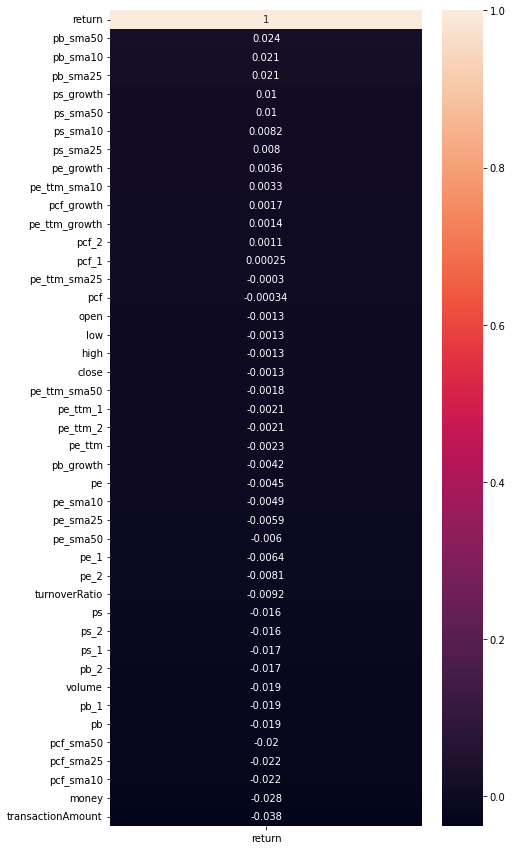

In [8]:
features = ['pe_ttm', 'pe', 'pb', 'ps', 'pcf']
sma_periods = [10,25,50]
df_lag = lag_feature_with_group(df, features, 2, 'code')
df_sma = sma(df_lag, features, sma_periods, 'code')
df_growth = growth(df_sma, features, 'code')
fig, ax = plt.subplots(figsize=(7,15))
sns.heatmap(df_lag.corr(numeric_only=True)[['return']].sort_values(by='return', ascending=False),annot=True);

In [9]:
test = lag_feature_with_group(test, features, 2, 'code')
test = sma(test, features, sma_periods, 'code')
test = growth(test, features, 'code')

df = df.dropna()
test = test.dropna()

In [10]:
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [11]:
def scaler(data,scl,timer):
    col=[i for i in data.columns if i not in timer]
    temp=data.loc[:,timer]
    temp.reset_index(drop=True,inplace=True)
    scaled_data=scl.fit_transform(data[col])
    scaled_data=pd.DataFrame(scaled_data,columns=col)
    new_data=pd.concat([scaled_data,temp],axis=1)
    return new_data

def unscaler(data,pred,timer,scl):
    col=[i for i in data.columns if i not in timer]
    temp=data.loc[:,col]
    temp['return']=pred
    temp=scl.inverse_transform(temp)
    temp=pd.DataFrame(temp,columns=col)
    unscaled_pred=temp.loc[:,'return']
    
    return unscaled_pred

In [12]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler(feature_range=(0, 1))
timer_train=['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code', 'date_time']
new_df=scaler(df,scaler_train,timer_train)

#same process for test dataset
test['return']=0
scaler_test = MinMaxScaler(feature_range=(0, 1))
timer=['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code']
new_test=scaler(test,scaler_test,timer)

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

2023-03-11 21:44:12.915084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def train_and_evaluate(train,test):
    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'n_jobs': -1,
      'verbose': -1
    }
    
    # Split features and target
    
    x = train[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 
                                                  'day_s', 'code', 'date_time','return']]]
    y = train['return']
    
    x_test = test[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 
                                                      'day_s', 'code', 'date_time','return']]]

    oof_predictions = np.zeros(x.shape[0])
    test_predictions = np.zeros(x_test.shape[0])
    scores = []
    
    # Create a KFold object
    gkf = TimeSeriesSplit(n_splits=n_fold,gap=group_gap)
    for fold, (trn_ind, val_ind) in enumerate(gkf.split(train['day'].values)):
    
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(units=64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1,input_shape=(x_train.shape[1],1)))
        model.add(LSTM(units=32))
        model.add(Dense(1))
 
        model.compile(loss='mean_squared_error', optimizer='adam', metrics='mae')
        model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
        
        #calculate validation prediction
        whole_pred=model.predict(x)
        #build a training dataset with our predictions
        oof_predictions[val_ind] = unscaler(train,whole_pred,timer_train,scaler_train)[val_ind]
        #calculate score
        y_val=unscaler(train,y,timer_train,scaler_train)[val_ind]
        rmspe_score = corr_score(y_val,oof_predictions[val_ind])
        print(f'Our out of folds corr_score is {rmspe_score}')
        scores.append(rmspe_score)
        
        #calculate test prediction
        test_pred=model.predict(x_test)
        scaled_test_pred=unscaler(test,test_pred,timer,scaler_test)
        test_predictions = test_predictions + scaled_test_pred
                
        #clear session
        keras.backend.clear_session()
        del model
        
    y=unscaler(train,y,timer_train,scaler_train)
    rmspe_score = corr_score(y, oof_predictions)
    print(scores)
    print(f'Our out of folds corr score is {rmspe_score}')
    plt.plot(y)
    plt.plot(oof_predictions)
    
    # Return test predictions
    return test_predictions

In [23]:
test_predictions = train_and_evaluate(new_df,new_test)

Training fold 1
4626/4626 - 83s - loss: 0.0112 - mae: 0.0784 - 83s/epoch - 18ms/step
1600/1600 [==============================] - 11s 7ms/step
Our out of folds corr_score is 0.07252567346561772
1097/1097 [==============================] - 8s 7ms/step
Training fold 2
9279/9279 - 155s - loss: 0.0278 - mae: 0.1206 - 155s/epoch - 17ms/step
1600/1600 [==============================] - 12s 7ms/step
Our out of folds corr_score is 0.046459929020609934
1097/1097 [==============================] - 8s 7ms/step
Training fold 3
13932/13932 - 229s - loss: 0.0228 - mae: 0.1086 - 229s/epoch - 16ms/step
1600/1600 [==============================] - 12s 7ms/step
Our out of folds corr_score is -0.07766325007861669
1097/1097 [==============================] - 7s 7ms/step
Training fold 4
18585/18585 - 307s - loss: 0.0193 - mae: 0.0989 - 307s/epoch - 17ms/step
1600/1600 [==============================] - 12s 7ms/step
Our out of folds corr_score is -0.09221743309729498
1097/1097 [=============================

KeyboardInterrupt: 

In [ ]:
# Save test predictions
test['return'] = test_predictions

prediction = test.loc[:,['date_time_x','return']]
prediction.columns=['date_time','return']
prediction.to_csv('submission.csv',index = False)

In [16]:
import random 
random.seed(20230304)

SUBMISSION_PATH = '/kaggle/working/submission.csv'

POINT_PER_DAY = 50

class QIDS:
    def __init__(self) -> None:
        self.__submission_path = SUBMISSION_PATH
        self.__current_idx = 0
        self.__predict_idx = 0
        self.__num_of_stocks = 54
        self.__point_per_day = POINT_PER_DAY
        self.__end = False
        self.__current_fundamental_df = None

        self.__fundamental_df = pd.read_csv(TEST_FUNADMENTAL_PATH)
        self.__market_df = pd.read_csv(TEST_MARKET_PATH)
        
        if len(self.__fundamental_df) / self.__num_of_stocks != len(self.__market_df)/ self.__num_of_stocks / self.__point_per_day:
            raise ValueError('The length of fundamental data and market data is not equal.')
        self.__length = len(self.__fundamental_df) / self.__num_of_stocks

        with open(self.__submission_path, 'w') as f:
            f.write('date_time,return\n') 
        
        print('Environment is initialized.')
    
    def is_end(self):
        return self.__end

    # return the fun
    def get_current_market(self):
        if self.__end:
            raise ValueError('The environment has ended.')

        # check if the current index is equal to the predict index
        if self.__current_idx != self.__predict_idx:
            raise ValueError('The current index is not equal to the predict index.')

        # load data of the current day
        fundamental_df = self.__fundamental_df.iloc[self.__current_idx * self.__num_of_stocks: (self.__current_idx + 1) * self.__num_of_stocks]
        market_df = self.__market_df.iloc[self.__current_idx * self.__num_of_stocks * self.__point_per_day: (self.__current_idx + 1) * self.__num_of_stocks * self.__point_per_day]
        
        # update the current index
        self.__current_idx += 1
        self.__current_fundamental_df = fundamental_df.reset_index()
        
        return fundamental_df, market_df

    def input_prediction(self, predict_ds: pd.Series):
        if self.__end:
            raise ValueError('The environment has ended.')

        # check if the current index is equal to the predict index plus 1
        if self.__current_idx != self.__predict_idx + 1:
            raise ValueError('The current index is not equal to the predict index plus 1.')

        # check the length of the predict_ds
        if len(predict_ds) != self.__num_of_stocks:
            raise ValueError('The length of input decisions is wrong.')
        
        # check the type of the predict_ds
        if type(predict_ds) != pd.Series:
            raise TypeError('The type of input decisions is wrong.')
        
        # write the prediction to the submission file
        with open(self.__submission_path, 'a') as f:
            for idx in range(len(predict_ds)):
                f.write(f"{str(self.__current_fundamental_df['date_time'][idx])},{str(predict_ds.iloc[idx])}\n")

                # must follow the stock order
                # f.write(f"s{idx}d{self.__current_idx},{str(predict_ds.iloc[idx])}\n")
        
        self.__predict_idx += 1
        if self.__predict_idx == self.__length:
            self.__end = True
            print('Data Feeding is finished.')
        

# initialize the environment
def make_env():
    if random.random() == 0.8396457911824297:
        return QIDS()
    else:
        raise ImportError('You cannot make this environment twice.')

In [18]:
#from qids_package.qids import *

env = make_env()

import random 
random.seed(42)

while not env.is_end():
	fundamental_df, market_df = env.get_current_market()
	
	l = []
	for idx in range(54):
		l.append(random.random())
	predict_ds =pd.Series(1)
	
	env.input_prediction(predict_ds)

ImportError: You cannot make this environment twice.

In [17]:
def train_and_evaluate(train,test):
    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'n_jobs': -1,
      'verbose': -1
    }
    
    # Split features and target
    
    x = train[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code', 'date_time','return']]]
    y = train['return']
    
    x_test = test[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code', 'date_time','return']]]

    oof_predictions = np.zeros(x.shape[0])
    test_predictions = np.zeros(x_test.shape[0])
    scores = []

    # Create a KFold object
    gkf = TimeSeriesSplit(n_splits=n_fold,gap=group_gap)
    for fold, (trn_ind, val_ind) in enumerate(gkf.split(train['day'].values)):
    
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        #这下面的用到lgb了
        train_dataset = lgb.Dataset(x_train, y_train)
        val_dataset = lgb.Dataset(x_val, y_val)
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 200, 
                          early_stopping_rounds = 20, 
                          verbose_eval = False,
                          feval = correlation)
        # Add predictions to the out of folds array
        
        oof_predictions[val_ind] = model.predict(x_val)
        
        rmspe_score = corr_score(y_val,oof_predictions[val_ind])
        print(f'Our out of folds corr_score is {rmspe_score}')
        scores.append(rmspe_score)
        test_predictions += model.predict(x_test) 
        
    rmspe_score = corr_score(y, oof_predictions)
    print(scores)
    print(f'Our out of folds corr score is {rmspe_score}')
    
    # Return test predictions
    return test_predictions